In [1]:
# -*- coding: utf-8 -*-
#-------------------------------------------------------------------------------

import itertools
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import re
import sys
import codecs
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer
#from nltk.stem.arlstem import ARLSTem
import gensim
from gensim.models.word2vec import Word2Vec


import keras
from keras import layers
from keras import optimizers

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.utils import to_categorical

import keras_metrics


Using TensorFlow backend.


In [35]:
data = pd.read_csv('All_Dataset - Copy.csv', encoding='utf-8')
data = data.sample(frac=1).reset_index(drop=True)
print(data.shape)
data.head()

(56674, 2)


,Tweet,Polarity
0,السماح_بالسينما_في_السعوديه هاللحين ايش فيها ...,neut
1,الميزانيه_السعوديه هذي هي الناس بس ماعندها ال...,pos
2,توقعاتكم لمباراه الهلال_التعاون الاثنين 7 30 ...,neut
3,مباريات اليوم عوده الجميع ل الوضع الطبيعي الاه...,neut
4,روما جحفلوا برشلونه بس جحفله من نوع مخزي جدا ب...,neg


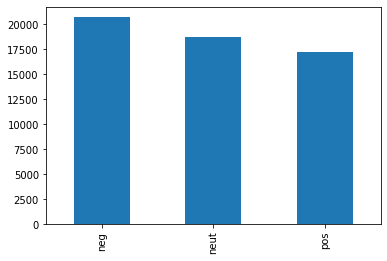

In [36]:
data['Polarity'].value_counts().sort_index().plot.bar()

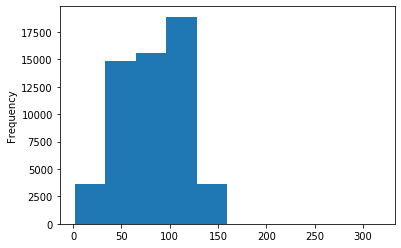

In [37]:
data['Tweet'].str.len().plot.hist()

In [38]:
def transform(x):
    if x == 'neg':
        return 0
    elif x == 'pos':
        return 1
    return 2
data['Sentiment'] = data['Polarity'].apply(transform)
data.head()

,Tweet,Polarity,Sentiment
0,السماح_بالسينما_في_السعوديه هاللحين ايش فيها ...,neut,2
1,الميزانيه_السعوديه هذي هي الناس بس ماعندها ال...,pos,1
2,توقعاتكم لمباراه الهلال_التعاون الاثنين 7 30 ...,neut,2
3,مباريات اليوم عوده الجميع ل الوضع الطبيعي الاه...,neut,2
4,روما جحفلوا برشلونه بس جحفله من نوع مخزي جدا ب...,neg,0


In [39]:
#remove users
data['clean'] = data['Tweet'].apply(lambda x: re.sub('(@[A-Za-z]+)', '', x, flags=re.UNICODE))

#remove hashtags
data['clean'] = data['clean'].apply(lambda x: re.sub('(#[أ-ي]+)|(_[أ-ي]+)', '', x, flags=re.UNICODE))

#remove letters, numbers & symbols
data['clean'] = data['clean'].apply(lambda x: re.sub('[a-zA-Z0-9@=$:.،%^*"#~£/&\n؟?!-_]', '', x, flags=re.UNICODE))

#arabic numbers
data['clean'] = data['clean'].apply(lambda x: re.sub('[٠١٢٣٤٥٦٧٨٩]', '', x, flags=re.UNICODE))

#nltk tokenize
data['clean'].apply(word_tokenize)
data['clean'] = data['clean'].apply(word_tokenize) 

#repeated letters
data['clean']= data['clean'].apply(lambda x: [''.join(ch for ch, _ in itertools.groupby(y)) for y in x])

#normalization
def normalizeArabic(text):
    text = re.sub("[إأٱآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "و", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    return(text)
data['clean']= data['clean'].apply(lambda x: [normalizeArabic(y) for y in x])

#remove stopwords
def get_stop_words():
    path = 'list.txt'
    stop_words = []
    with codecs.open(path, "r", encoding="utf-8", errors="ignore") as myfile:
        stop_words = myfile.readlines()
    stop_words = [word.strip() for word in stop_words]
    return stop_words

stop_words = get_stop_words()
data['clean']= data['clean'].apply(lambda x: [item for item in x if item not in stop_words])

#remove emojis
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

data['clean']= data['clean'].apply(lambda x: [remove_emoji(y) for y in x])

data.head(10)

,Tweet,Polarity,Sentiment,clean
0,السماح_بالسينما_في_السعوديه هاللحين ايش فيها ...,neut,2,"[السماح, هالحين, ايش, التورنات, تشوف, الفلم, م..."
1,الميزانيه_السعوديه هذي هي الناس بس ماعندها ال...,pos,1,"[الميزانيه, هذي, الناس, بس, ماعندها, الكلام, ل..."
2,توقعاتكم لمباراه الهلال_التعاون الاثنين 7 30 ...,neut,2,"[توقعاتكم, لمباراه, الهلال, الاثنين, كاس]"
3,مباريات اليوم عوده الجميع ل الوضع الطبيعي الاه...,neut,2,"[مباريات, عوده, الجميع, الوضع, الطبيعي, الاهلي..."
4,روما جحفلوا برشلونه بس جحفله من نوع مخزي جدا ب...,neg,0,"[روما, جحفلوا, برشلونه, بس, جحفله, نوع, مخزي, ..."
5,ان جلسنا بالبيت زادت فاتوره الكهرب و ان طلعنا ...,neg,0,"[جلسنا, بالبيت, زادت, فاتوره, الكهرب, طلعنا, ل..."
6,الهلال يرفض الخساره امام الفتح 3 3 ومتعه كره ا...,pos,1,"[الهلال, يرفض, الخساره, الفتح, ومتعه, كره, القدم]"
7,الحمد لله امطر خير وبركه تعليق_الدراسه_في_القصيم,pos,1,"[الحمد, امطر, خير, وبركه, تعليق]"
8,هرم النجاح لاي بطل دوري قوه لاعبين قوه حظ قوه...,neut,2,"[هرم, النجاح, لاي, بطل, دوري, قوه, لاعبين, قوه..."
9,سنه كامله من الحكم الحوثي الهمجي كفاااااااااا...,neg,0,"[سنه, كامله, الحكم, الحوثي, الهمجي, كفايه, صنع..."


In [40]:
CBOW = Word2Vec.load('aravec/tweets_cbow_100')
CBOWE = CBOW.wv.get_keras_embedding()

In [41]:
# def buildWordVector(tokens, size):
#     vec = np.zeros(size).reshape((1, size))
#     count = 0.
#     for word in tokens:
#         try:
#             vec += CBOW[word].reshape((1, size))
#             count += 1.
#         except KeyError: # handling the case where the token is not
#             continue
#     if count != 0:
#         vec /= count
#     return vec

# X_train = np.concatenate([buildWordVector(x, 100) for x in data['clean']])
# X_train.shape

In [42]:
y = to_categorical(data['Sentiment'].values)

In [43]:
tokenizer = Tokenizer(num_words=len(data['clean']), split=" ")
tokenizer.fit_on_texts(data['clean'].values)

X = tokenizer.texts_to_sequences(data['clean'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length
X[:5]

array([[    0,     0,     0,     0,     0,     0,     0,     0,    10,
         4076,   287, 35366,  1147,  2379,   122,  8799, 14922,  9821,
        35367,  3100, 14923, 35368, 35369],
       [    0,     0,     0,     0,    11,   120,   127,    21, 35370,
          842,   203,   120,  4077, 23980,   124,  4284,   636,  4536,
         5810,  1776,  1009,  2103, 12770],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
         2316,   715,     1,  1600,    69],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,   292,   128,   318,
          537,  1053,     5,     6,   139],
       [    0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,    34, 35371,     4,
           21,  3227,  2706,  9822,     4]])

In [44]:
X.shape

(56674, 23)

## Prepare metrics

In [45]:
from keras import backend as K


# calculate f score
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [46]:
# metrics
metrics = [
    'accuracy',
    keras_metrics.precision(),
    keras_metrics.recall(),
    f1,
]

tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> tp
tracking <tf.Variable 'Variable:0' shape=() dtype=int32, numpy=0> fn


In [47]:
# hyperparamters
BATCH_SIZE = 64
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.3
EPOCHS = 10

#  Build the models

## Stacked-LSTM

In [16]:
%time
lstm_model_input = layers.Input(shape=(X.shape[1],))
x = CBOWE(lstm_model_input)
x = layers.LSTM(100, return_sequences=True)(x)
x = layers.LSTM(100, return_sequences=False)(x)
x = layers.Dropout(.5)(x)
x = layers.Dense(3, activation='softmax')(x)
lstm_model = keras.models.Model(inputs=lstm_model_input, outputs=x)

lstm_model.compile(loss='categorical_crossentropy', 
                   optimizer=optimizers.Adam(lr=LEARNING_RATE),
                   metrics=metrics,)
lstm_model.fit(X, y, 
               validation_split=VALIDATION_SPLIT, 
               batch_size=BATCH_SIZE, 
               epochs=EPOCHS)

Train on 39671 samples, validate on 17003 samples
Epoch 1/10
39671/39671 [==============================] - 78s 2ms/step - loss: 0.8330 - accuracy: 0.6185 - precision: 0.6178 - recall: 0.3377 - f1: 0.5515 - val_loss: 0.7316 - val_accuracy: 0.6858 - val_precision: 0.7423 - val_recall: 0.5661 - val_f1: 0.6590
Epoch 2/10
39671/39671 [==============================] - 71s 2ms/step - loss: 0.6610 - accuracy: 0.7229 - precision: 0.7602 - recall: 0.6660 - f1: 0.7065 - val_loss: 0.7009 - val_accuracy: 0.6997 - val_precision: 0.7651 - val_recall: 0.5563 - val_f1: 0.6796
Epoch 3/10
39671/39671 [==============================] - 87s 2ms/step - loss: 0.5597 - accuracy: 0.7719 - precision: 0.8123 - recall: 0.7376 - f1: 0.7636 - val_loss: 0.7123 - val_accuracy: 0.7054 - val_precision: 0.7323 - val_recall: 0.6384 - val_f1: 0.6989
Epoch 4/10
39671/39671 [==============================] - 74s 2ms/step - loss: 0.4707 - accuracy: 0.8155 - precision: 0.8493 - recall: 0.7969 - f1: 0.8106 - val_loss: 0.7193

In [17]:
lstm_model.save('outputs/stacked-lstm-1')

In [18]:
lstm_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 26)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 26, 100)           33167900  
_________________________________________________________________
lstm_3 (LSTM)                (None, 26, 100)           80400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 303       
Total params: 33,329,003
Trainable params: 161,103
Non-trainable params: 33,167,900
_________________________________________

## Stacked-GRU

In [48]:
%time
gru_model_input = layers.Input(shape=(X.shape[1],))
x = CBOWE(gru_model_input)
x = layers.GRU(100, return_sequences=True)(x)
x = layers.GRU(100, return_sequences=False)(x)
x = layers.Dropout(.5)(x)
x = layers.Dense(3, activation='softmax')(x)
gru_model = keras.models.Model(inputs=gru_model_input, outputs=x)

gru_model.compile(loss='categorical_crossentropy', 
                   optimizer=optimizers.Adam(lr=LEARNING_RATE),
                   metrics=metrics,)
gru_model.fit(X, y, 
               validation_split=VALIDATION_SPLIT, 
               batch_size=BATCH_SIZE, 
               epochs=EPOCHS)
gru_model.save('outputs/stacked-gru-1')

Wall time: 0 ns
Train on 39671 samples, validate on 17003 samples
Epoch 1/10
39671/39671 [==============================] - 63s 2ms/step - loss: 0.8673 - accuracy: 0.5984 - precision: 0.5653 - recall: 0.3659 - f1: 0.5495 - val_loss: 0.7507 - val_accuracy: 0.6682 - val_precision: 0.7286 - val_recall: 0.5372 - val_f1: 0.6407
Epoch 2/10
39671/39671 [==============================] - 63s 2ms/step - loss: 0.6875 - accuracy: 0.7097 - precision: 0.7290 - recall: 0.6519 - f1: 0.6931 - val_loss: 0.7140 - val_accuracy: 0.6934 - val_precision: 0.6890 - val_recall: 0.7179 - val_f1: 0.6760
Epoch 3/10
39671/39671 [==============================] - 64s 2ms/step - loss: 0.5973 - accuracy: 0.7541 - precision: 0.7756 - recall: 0.7174 - f1: 0.7458 - val_loss: 0.6989 - val_accuracy: 0.6953 - val_precision: 0.7312 - val_recall: 0.6418 - val_f1: 0.6857
Epoch 4/10
39671/39671 [==============================] - 64s 2ms/step - loss: 0.5188 - accuracy: 0.7921 - precision: 0.8180 - recall: 0.7749 - f1: 0.7869 - 

In [49]:
gru_model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 23)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 23, 100)           33167900  
_________________________________________________________________
gru_7 (GRU)                  (None, 23, 100)           60300     
_________________________________________________________________
gru_8 (GRU)                  (None, 100)               60300     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 303       
Total params: 33,288,803
Trainable params: 120,903
Non-trainable params: 33,167,900
_________________________________________